In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# BrainMRIDataset class

In [3]:
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, skip_empty=True):
        self.image_mask_pairs = []
        self.transform = transform
        self.skip_empty = skip_empty
        for patient_folder in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient_folder)
            if not os.path.isdir(patient_path): continue
            for file in os.listdir(patient_path):
                if file.endswith(".tif") and "_mask" not in file:
                    img_path = os.path.join(patient_path, file)
                    msk_path = img_path.replace(".tif", "_mask.tif")
                    if os.path.exists(msk_path):
                        if self.skip_empty:
                            arr = np.array(Image.open(msk_path).convert("L"))
                            if arr.sum() == 0: continue
                        self.image_mask_pairs.append((img_path, msk_path))

    def __len__(self): return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, msk_path = self.image_mask_pairs[idx]
        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(msk_path).convert("L")
        if self.transform:
            image = self.transform(image)
            mask  = self.transform(mask)
        return image, (mask > 0).float()



print("Step 1 done")

Step 1 done


# Data transforms + loaders

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = BrainMRIDataset("/kaggle/input/lgg-mri-segmentation/kaggle_3m", transform)
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)


print("Step 2 done")

Step 2 done


# Diceloss and dice_score

In [5]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid to get probabilities if not already applied
        inputs = torch.sigmoid(inputs)

        # Flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate intersection and union
        intersection = (inputs * targets).sum()
        total = inputs.sum() + targets.sum()

        dice = (2. * intersection + self.smooth) / (total + self.smooth)
        return 1 - dice

print('Compeleted this step')

Compeleted this step


# Attention Block

In [6]:
class AttentionBlock(nn.Module):
    def __init__(self, g_channels, x_channels, inter_channels):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(g_channels, inter_channels, kernel_size=1),
            nn.BatchNorm2d(inter_channels)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(x_channels, inter_channels, kernel_size=1),
            nn.BatchNorm2d(inter_channels)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


# MambaBlock (custom block used in AttentionUNetMamba)

In [7]:
class MambaBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MambaBlock, self).__init__()
        self.linear1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.A_d = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.B_d = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.C = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.D = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, u):
        x = F.relu(self.linear1(u))
        state = self.A_d(x) + self.B_d(u)
        out = self.C(state) + self.D(u)
        return out


# AttentionUNetMamba

In [8]:
class AttentionUNetMamba(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(AttentionUNetMamba, self).__init__()
        filters = [64, 128, 256, 512]

        # Encoder
        self.enc1 = self.conv_block(in_channels, filters[0])
        self.enc2 = self.conv_block(filters[0], filters[1])
        self.enc3 = self.conv_block(filters[1], filters[2])
        self.enc4 = self.conv_block(filters[2], filters[3])

        self.pool = nn.MaxPool2d(kernel_size=2)

        # Bottleneck
        self.bottleneck = self.conv_block(filters[3], filters[3]*2)

        # Attention Blocks
        self.att4 = AttentionBlock(g_channels=filters[3], x_channels=filters[3], inter_channels=filters[2])
        self.att3 = AttentionBlock(g_channels=filters[2], x_channels=filters[2], inter_channels=filters[1])
        self.att2 = AttentionBlock(g_channels=filters[1], x_channels=filters[1], inter_channels=filters[0])
        self.att1 = AttentionBlock(g_channels=filters[0], x_channels=filters[0], inter_channels=32)

        # Decoder with Mamba Blocks
        self.up4 = nn.ConvTranspose2d(filters[3]*2, filters[3], kernel_size=2, stride=2)
        self.dec4 = MambaBlock(in_channels=filters[3]*2, out_channels=filters[3])

        self.up3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.dec3 = MambaBlock(in_channels=filters[2]*2, out_channels=filters[2])

        self.up2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.dec2 = MambaBlock(in_channels=filters[1]*2, out_channels=filters[1])

        self.up1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.dec1 = MambaBlock(in_channels=filters[0]*2, out_channels=filters[0])

        # Final output layer
        self.final = nn.Conv2d(filters[0], out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        e4_att = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4_att], dim=1))

        d3 = self.up3(d4)
        e3_att = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3_att], dim=1))

        d2 = self.up2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.up1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        out = self.final(d1)
        return out


print("Step completed: Attention UNet with Mamba")


Step completed: Attention UNet with Mamba


# Define Traditional U-Net Baseline

In [9]:
# Traditional UNet (from-scratch implementation)
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        filters = [64, 128, 256, 512]
        # Encoder
        self.enc1 = self.conv_block(in_channels, filters[0])
        self.enc2 = self.conv_block(filters[0], filters[1])
        self.enc3 = self.conv_block(filters[1], filters[2])
        self.enc4 = self.conv_block(filters[2], filters[3])
        self.pool = nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = self.conv_block(filters[3], filters[3]*2)
        # Decoder
        self.up4 = nn.ConvTranspose2d(filters[3]*2, filters[3], kernel_size=2, stride=2)
        self.dec4 = self.conv_block(filters[3]*2, filters[3])
        self.up3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.dec3 = self.conv_block(filters[2]*2, filters[2])
        self.up2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.dec2 = self.conv_block(filters[1]*2, filters[1])
        self.up1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.dec1 = self.conv_block(filters[0]*2, filters[0])
        self.final = nn.Conv2d(filters[0], out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))
        d4 = self.up4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        out = self.final(d1)
        return out

print("UNet baseline defined successfully.")

UNet baseline defined successfully.


In [10]:
def dice_score(preds, targets, smooth=1e-5):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = ((2. * intersection + smooth) / (union + smooth))
    return dice.mean().item()


#  Train Both Models on the Same Data

In [11]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models
attention_model = AttentionUNetMamba().to(device)
unet_model = UNet().to(device)

# Losses and optimizers
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()
optimizer_att = optim.Adam(attention_model.parameters(), lr=1e-4)
optimizer_unet = optim.Adam(unet_model.parameters(), lr=1e-4)


In [12]:
# num_epochs = 10
# for epoch in range(num_epochs):
#     # ---- Train Attention-Mamba U-Net ----
#     attention_model.train()
#     att_train_loss = 0
#     for images, masks in train_loader:
#         images, masks = images.to(device), masks.to(device)
#         preds = attention_model(images)
#         loss = bce_loss(preds, masks) + dice_loss(preds, masks)
#         att_train_loss += loss.item()
#         optimizer_att.zero_grad()
#         loss.backward()
#         optimizer_att.step()

#     # ---- Train Traditional U-Net ----
#     unet_model.train()
#     unet_train_loss = 0
#     for images, masks in train_loader:
#         images, masks = images.to(device), masks.to(device)
#         preds = unet_model(images)
#         loss = bce_loss(preds, masks) + dice_loss(preds, masks)
#         unet_train_loss += loss.item()
#         optimizer_unet.zero_grad()
#         loss.backward()
#         optimizer_unet.step()

#     # ---- Validation for both ----
#     attention_model.eval()
#     unet_model.eval()
#     att_val_loss = att_val_dice = 0
#     unet_val_loss = unet_val_dice = 0
#     att_val_iou = unet_val_iou = 0

#     with torch.no_grad():
#         for images, masks in val_loader:
#             images, masks = images.to(device), masks.to(device)

#             # ---- Attention Model Evaluation ----
#             preds_att = attention_model(images)
#             loss_att = bce_loss(preds_att, masks) + dice_loss(preds_att, masks)
#             att_val_loss += loss_att.item()
#             att_val_dice += dice_score(preds_att, masks)

#             preds_att_bin = (torch.sigmoid(preds_att) > 0.5).float()
#             inter = (preds_att_bin * masks).sum(dim=(1,2,3))
#             union = preds_att_bin.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3)) - inter
#             iou = ((inter + 1e-5) / (union + 1e-5)).mean().item()
#             att_val_iou += iou

#             # ---- U-Net Evaluation ----
#             preds_unet = unet_model(images)
#             loss_unet = bce_loss(preds_unet, masks) + dice_loss(preds_unet, masks)
#             unet_val_loss += loss_unet.item()
#             unet_val_dice += dice_score(preds_unet, masks)

#             preds_unet_bin = (torch.sigmoid(preds_unet) > 0.5).float()
#             inter = (preds_unet_bin * masks).sum(dim=(1,2,3))
#             union = preds_unet_bin.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3)) - inter
#             iou = ((inter + 1e-5) / (union + 1e-5)).mean().item()
#             unet_val_iou += iou

#     # ---- Print Epoch Metrics ----
#     print(f"Epoch {epoch+1}/{num_epochs}")
#     print(f"  Attention U-Net: Train Loss: {att_train_loss/len(train_loader):.4f}, Val Loss: {att_val_loss/len(val_loader):.4f}, Val Dice: {att_val_dice/len(val_loader):.4f}, Val IoU: {att_val_iou/len(val_loader):.4f}")
#     print(f"  U-Net         : Train Loss: {unet_train_loss/len(train_loader):.4f}, Val Loss: {unet_val_loss/len(val_loader):.4f}, Val Dice: {unet_val_dice/len(val_loader):.4f}, Val IoU: {unet_val_iou/len(val_loader):.4f}")


In [13]:
def show_predictions(model, loader, title="Predictions", num_samples=3):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 4 * num_samples))
    axes = np.atleast_2d(axes)

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            preds = torch.sigmoid(preds)

            for i in range(images.shape[0]):
                if images_shown >= num_samples:
                    break

                image = images[i].cpu()
                mask = masks[i].cpu().squeeze().numpy()
                pred = preds[i].cpu().squeeze().numpy()

                # Convert from (C, H, W) to (H, W, C) for RGB
                image_np = image.permute(1, 2, 0).numpy()

                # Plot input image
                axes[images_shown, 0].imshow(image_np)
                axes[images_shown, 0].set_title("Input")

                # Plot ground truth mask
                axes[images_shown, 1].imshow(mask, cmap='gray')
                axes[images_shown, 1].set_title("Ground Truth")

                # Plot predicted mask
                axes[images_shown, 2].imshow(pred > 0.5, cmap='gray')
                axes[images_shown, 2].set_title("Prediction")

                for ax in axes[images_shown]:
                    ax.axis('off')

                images_shown += 1

            if images_shown >= num_samples:
                break

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


In [15]:
def compute_classification_metrics(preds, targets):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    y_pred = preds.cpu().numpy().astype(int).flatten()
    y_true = targets.cpu().numpy().astype(int).flatten()

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    return precision, recall, f1, cm


In [16]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, device, title='Model'):
    model.eval()
    images, masks = next(iter(data_loader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        preds = model(images)
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float()

    for i in range(3):  # Show first 3 samples
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(images[i][0].cpu(), cmap='gray')
        axs[0].set_title("Input Image")
        axs[1].imshow(masks[i][0].cpu(), cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(preds[i][0].cpu(), cmap='gray')
        axs[2].set_title(f"{title} Prediction")
        for ax in axs: ax.axis('off')
        plt.tight_layout()
        plt.show()



Epoch 1/10
--- Attention U-Net ---
Train Loss: 0.5494, Val Loss: 0.3238
Val Dice: 0.6251, Val IoU: 0.5298
Precision: 0.8285, Recall: 0.7242, F1 Score: 0.7728
Confusion Matrix:
[[4314817   24873]
 [  45766  120144]]

--- U-Net ---
Train Loss: 1.3263, Val Loss: 1.1831
Val Dice: 0.6343, Val IoU: 0.5327
Precision: 0.7857, Recall: 0.7499, F1 Score: 0.7674
Confusion Matrix:
[[4305758   33932]
 [  41499  124411]]


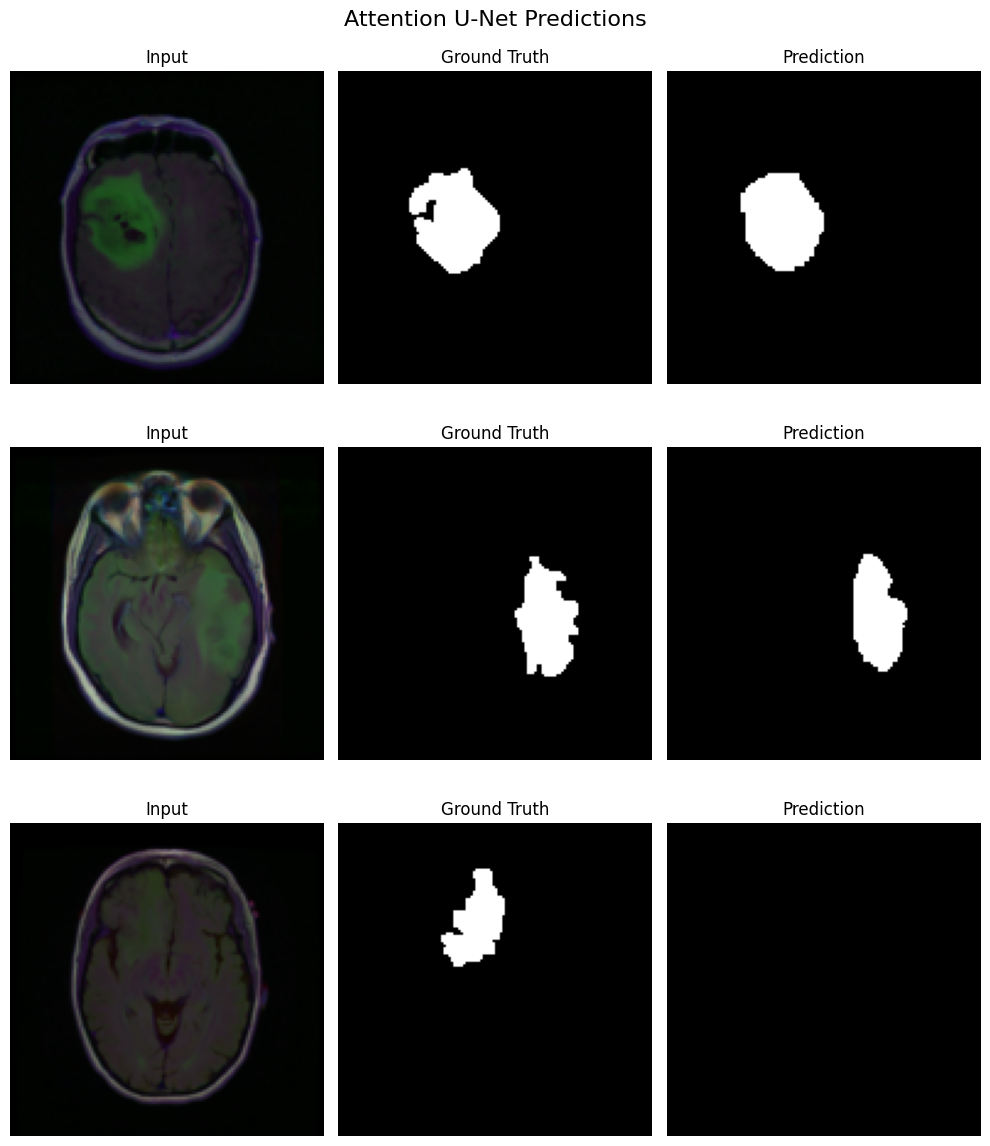

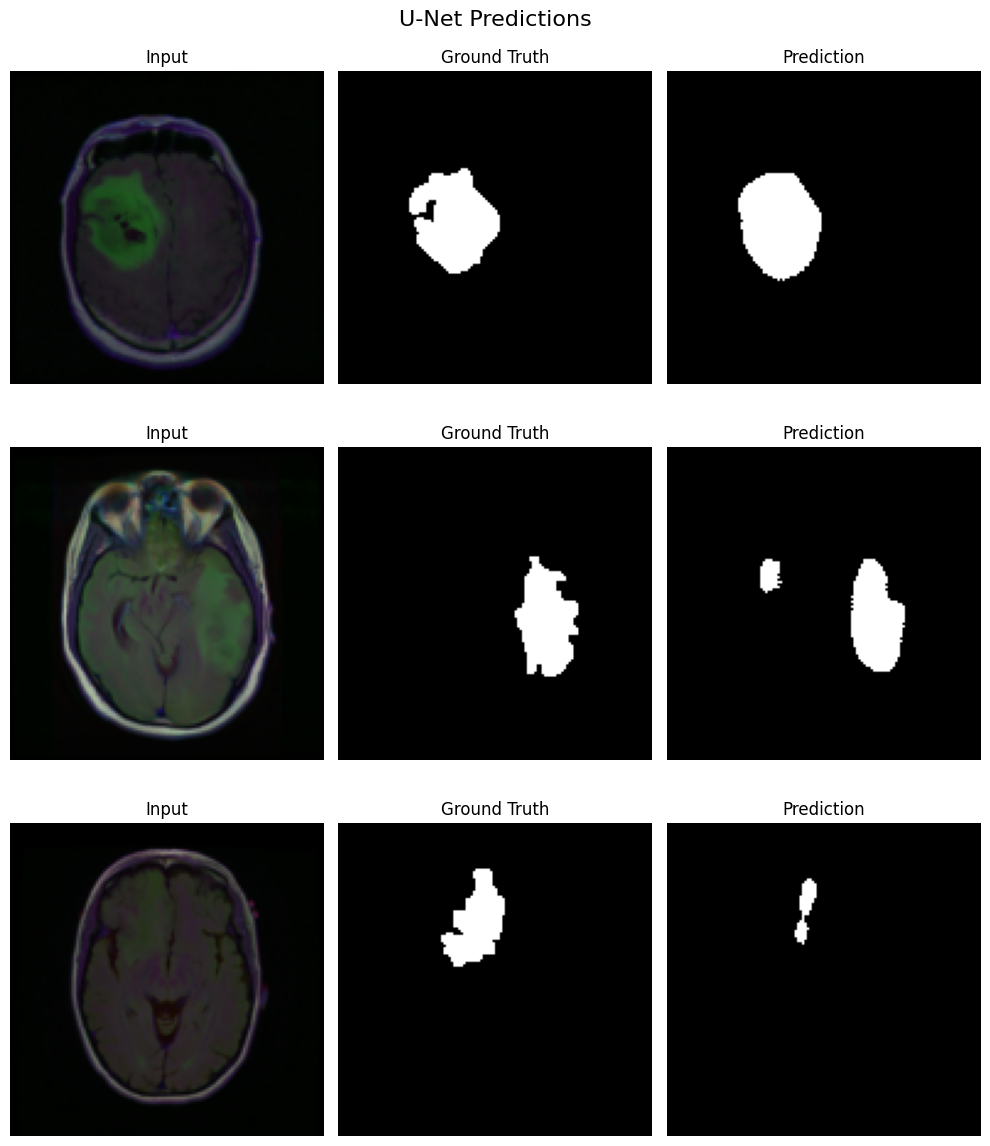


Epoch 2/10
--- Attention U-Net ---
Train Loss: 0.3107, Val Loss: 0.2875
Val Dice: 0.6975, Val IoU: 0.5956
Precision: 0.7943, Recall: 0.8058, F1 Score: 0.8000
Confusion Matrix:
[[4305061   34629]
 [  32212  133698]]

--- U-Net ---
Train Loss: 1.1325, Val Loss: 1.0592
Val Dice: 0.7243, Val IoU: 0.6124
Precision: 0.7673, Recall: 0.8683, F1 Score: 0.8147
Confusion Matrix:
[[4295992   43698]
 [  21847  144063]]

Epoch 3/10
--- Attention U-Net ---
Train Loss: 0.2605, Val Loss: 0.2387
Val Dice: 0.7228, Val IoU: 0.6315
Precision: 0.8758, Recall: 0.8003, F1 Score: 0.8364
Confusion Matrix:
[[4320865   18825]
 [  33124  132786]]

--- U-Net ---
Train Loss: 1.0096, Val Loss: 0.9860
Val Dice: 0.6606, Val IoU: 0.5263
Precision: 0.5630, Recall: 0.9653, F1 Score: 0.7112
Confusion Matrix:
[[4215358  124332]
 [   5757  160153]]

Epoch 4/10
--- Attention U-Net ---
Train Loss: 0.2164, Val Loss: 0.2140
Val Dice: 0.7349, Val IoU: 0.6400
Precision: 0.9301, Recall: 0.7763, F1 Score: 0.8463
Confusion Matrix:
[

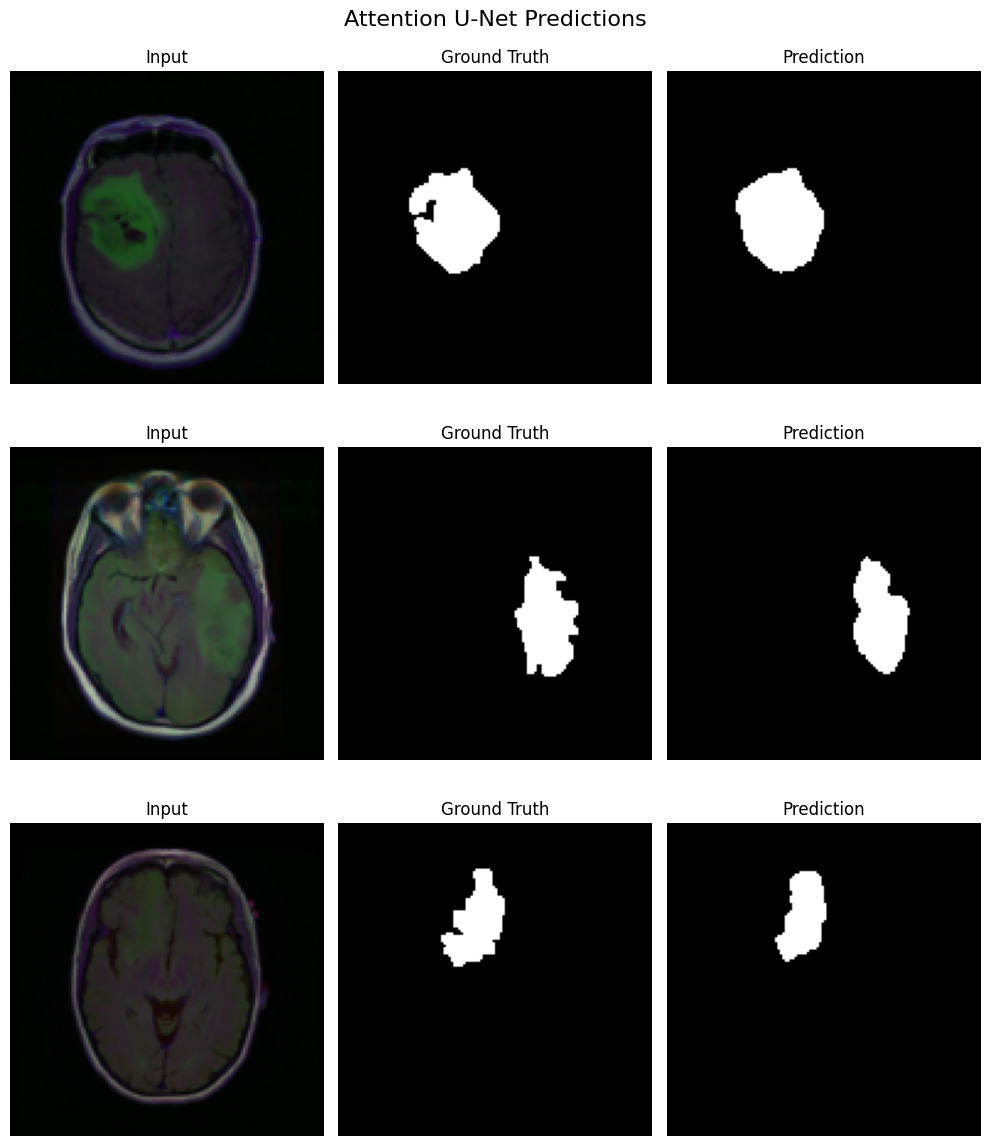

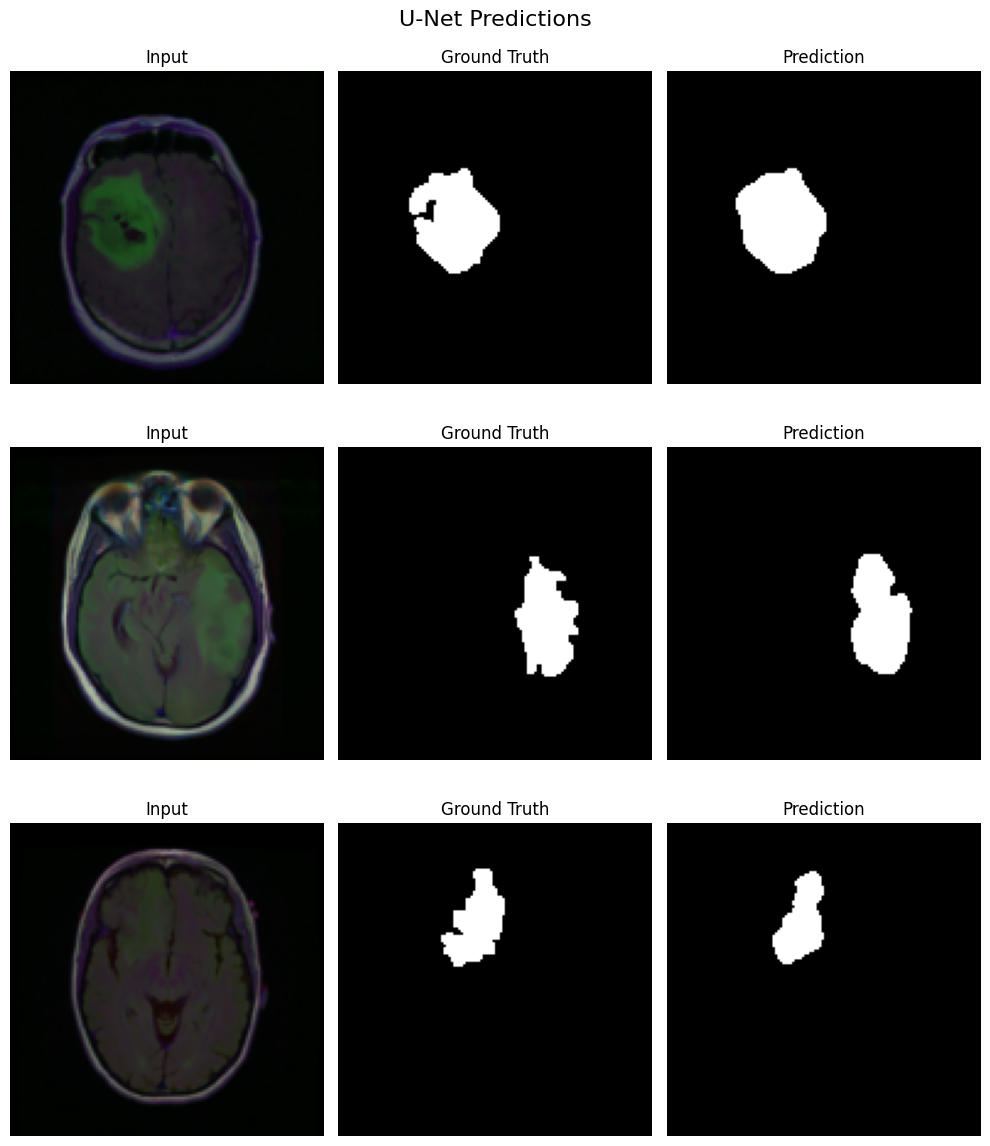


Epoch 7/10
--- Attention U-Net ---
Train Loss: 0.1383, Val Loss: 0.1652
Val Dice: 0.8136, Val IoU: 0.7238
Precision: 0.9015, Recall: 0.8625, F1 Score: 0.8816
Confusion Matrix:
[[4324049   15641]
 [  22805  143105]]

--- U-Net ---
Train Loss: 0.6030, Val Loss: 0.5850
Val Dice: 0.8033, Val IoU: 0.7167
Precision: 0.8651, Recall: 0.8941, F1 Score: 0.8794
Confusion Matrix:
[[4316565   23125]
 [  17571  148339]]

Epoch 8/10
--- Attention U-Net ---
Train Loss: 0.1358, Val Loss: 0.1599
Val Dice: 0.8253, Val IoU: 0.7383
Precision: 0.9126, Recall: 0.8570, F1 Score: 0.8840
Confusion Matrix:
[[4326081   13609]
 [  23724  142186]]

--- U-Net ---
Train Loss: 0.5112, Val Loss: 0.5143
Val Dice: 0.8327, Val IoU: 0.7484
Precision: 0.8876, Recall: 0.8910, F1 Score: 0.8893
Confusion Matrix:
[[4320962   18728]
 [  18079  147831]]

Epoch 9/10
--- Attention U-Net ---
Train Loss: 0.1286, Val Loss: 0.1433
Val Dice: 0.8358, Val IoU: 0.7524
Precision: 0.8968, Recall: 0.9019, F1 Score: 0.8994
Confusion Matrix:
[

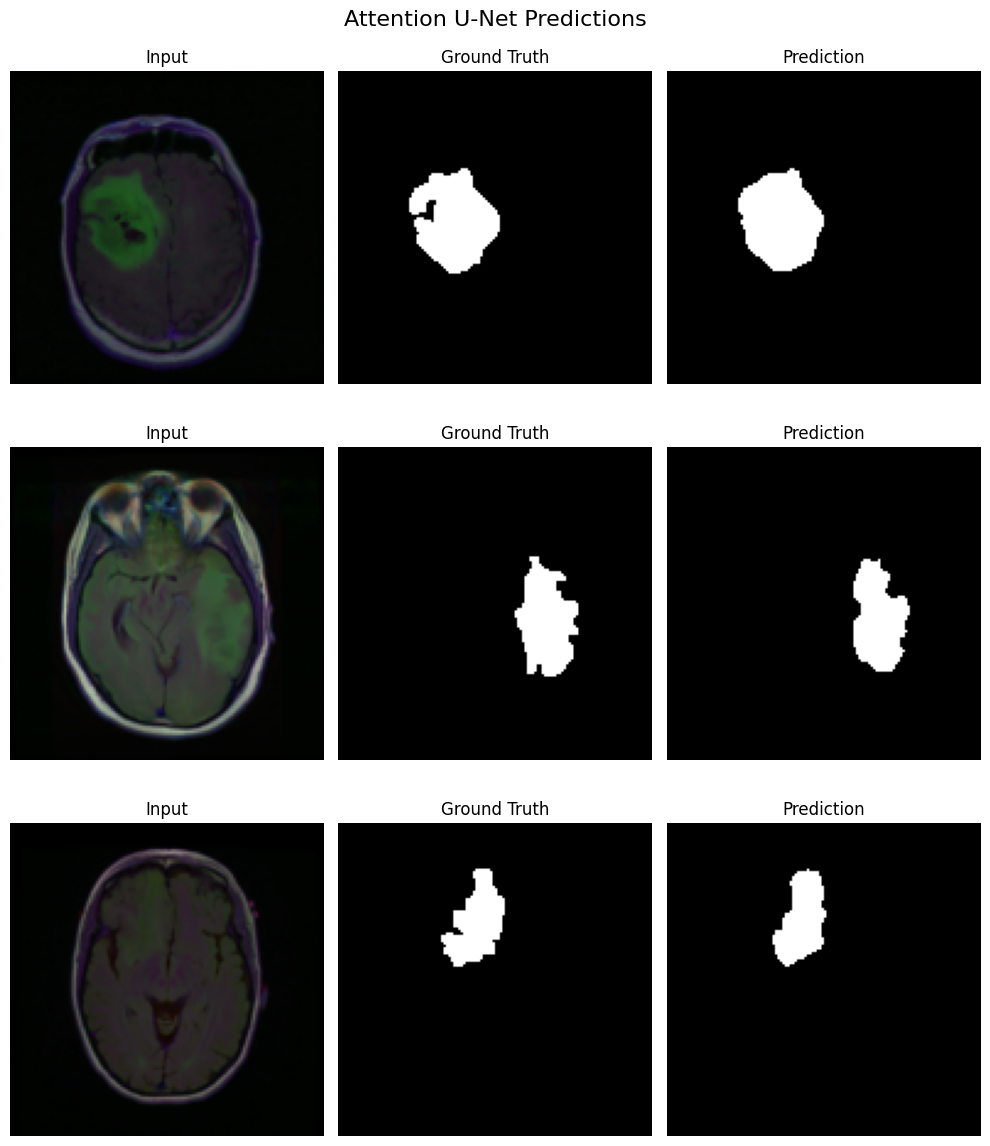

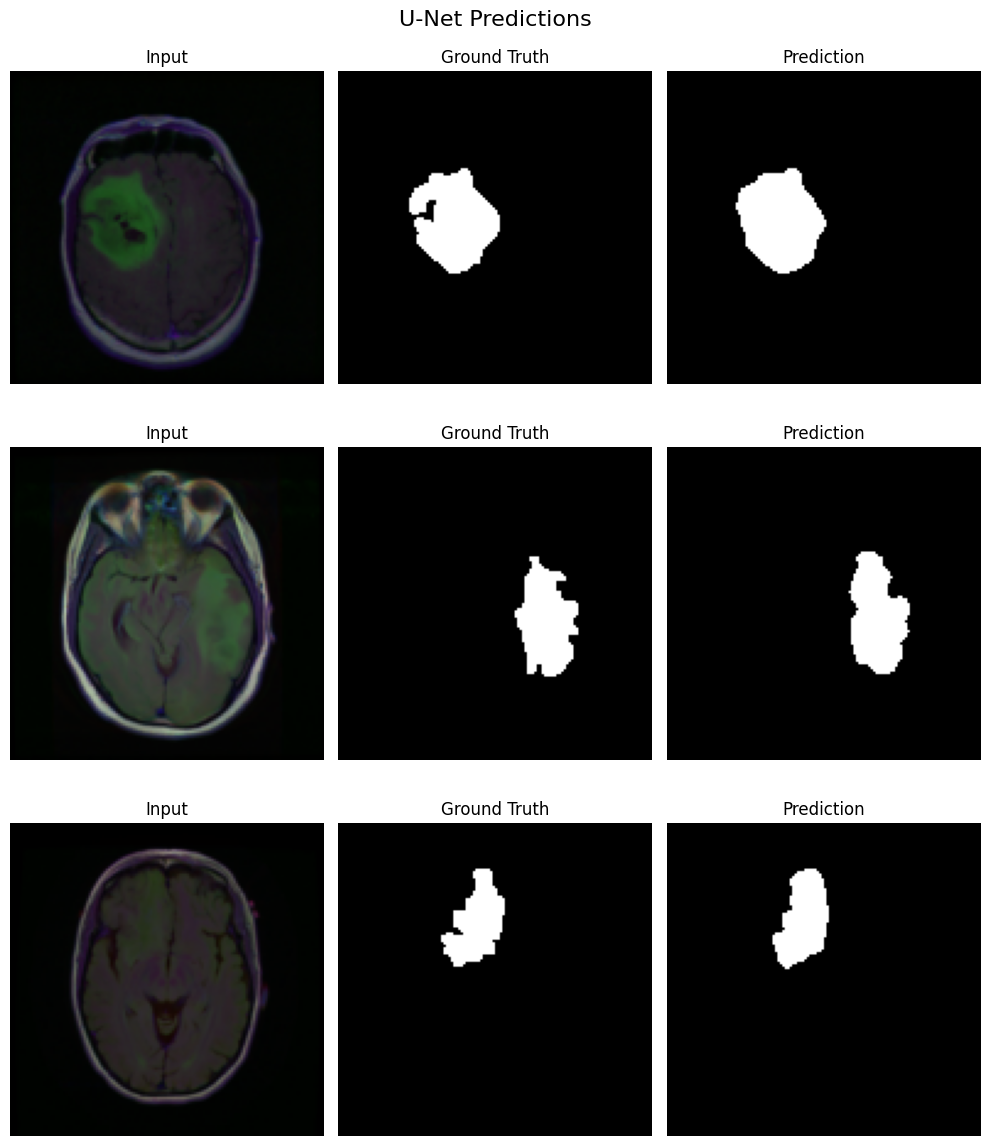

In [17]:
# ----------------- TRAINING + VALIDATION LOOP -----------------
num_epochs = 10
for epoch in range(num_epochs):
    # ---- Train Attention-Mamba U-Net ----
    attention_model.train()
    att_train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        preds = attention_model(images)
        loss = bce_loss(preds, masks) + dice_loss(preds, masks)
        att_train_loss += loss.item()
        optimizer_att.zero_grad()
        loss.backward()
        optimizer_att.step()

    # ---- Train Traditional U-Net ----
    unet_model.train()
    unet_train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        preds = unet_model(images)
        loss = bce_loss(preds, masks) + dice_loss(preds, masks)
        unet_train_loss += loss.item()
        optimizer_unet.zero_grad()
        loss.backward()
        optimizer_unet.step()

    # ---- Validation for both ----
    attention_model.eval()
    unet_model.eval()
    att_val_loss = att_val_dice = 0
    unet_val_loss = unet_val_dice = 0
    att_val_iou = unet_val_iou = 0

    # Initialize arrays for classification metrics
    all_att_preds = []
    all_att_targets = []
    all_unet_preds = []
    all_unet_targets = []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            # ---- Attention U-Net Evaluation ----
            preds_att = attention_model(images)
            loss_att = bce_loss(preds_att, masks) + dice_loss(preds_att, masks)
            att_val_loss += loss_att.item()
            att_val_dice += dice_score(preds_att, masks)

            preds_att_bin = (torch.sigmoid(preds_att) > 0.5).float()
            inter = (preds_att_bin * masks).sum(dim=(1,2,3))
            union = preds_att_bin.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3)) - inter
            iou = ((inter + 1e-5) / (union + 1e-5)).mean().item()
            att_val_iou += iou

            all_att_preds.extend(preds_att_bin.view(-1).cpu().numpy())
            all_att_targets.extend(masks.view(-1).cpu().numpy())

            # ---- U-Net Evaluation ----
            preds_unet = unet_model(images)
            loss_unet = bce_loss(preds_unet, masks) + dice_loss(preds_unet, masks)
            unet_val_loss += loss_unet.item()
            unet_val_dice += dice_score(preds_unet, masks)

            preds_unet_bin = (torch.sigmoid(preds_unet) > 0.5).float()
            inter = (preds_unet_bin * masks).sum(dim=(1,2,3))
            union = preds_unet_bin.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3)) - inter
            iou = ((inter + 1e-5) / (union + 1e-5)).mean().item()
            unet_val_iou += iou

            all_unet_preds.extend(preds_unet_bin.view(-1).cpu().numpy())
            all_unet_targets.extend(masks.view(-1).cpu().numpy())

    # ---- Metrics ----
    att_precision = precision_score(all_att_targets, all_att_preds, zero_division=0)
    att_recall = recall_score(all_att_targets, all_att_preds, zero_division=0)
    att_f1 = f1_score(all_att_targets, all_att_preds, zero_division=0)
    att_conf_matrix = confusion_matrix(all_att_targets, all_att_preds)

    unet_precision = precision_score(all_unet_targets, all_unet_preds, zero_division=0)
    unet_recall = recall_score(all_unet_targets, all_unet_preds, zero_division=0)
    unet_f1 = f1_score(all_unet_targets, all_unet_preds, zero_division=0)
    unet_conf_matrix = confusion_matrix(all_unet_targets, all_unet_preds)

    # ---- Print Epoch Metrics ----
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"--- Attention U-Net ---")
    print(f"Train Loss: {att_train_loss/len(train_loader):.4f}, Val Loss: {att_val_loss/len(val_loader):.4f}")
    print(f"Val Dice: {att_val_dice/len(val_loader):.4f}, Val IoU: {att_val_iou/len(val_loader):.4f}")
    print(f"Precision: {att_precision:.4f}, Recall: {att_recall:.4f}, F1 Score: {att_f1:.4f}")
    print(f"Confusion Matrix:\n{att_conf_matrix}")

    print(f"\n--- U-Net ---")
    print(f"Train Loss: {unet_train_loss/len(train_loader):.4f}, Val Loss: {unet_val_loss/len(val_loader):.4f}")
    print(f"Val Dice: {unet_val_dice/len(val_loader):.4f}, Val IoU: {unet_val_iou/len(val_loader):.4f}")
    print(f"Precision: {unet_precision:.4f}, Recall: {unet_recall:.4f}, F1 Score: {unet_f1:.4f}")
    print(f"Confusion Matrix:\n{unet_conf_matrix}")

    # ---- Optional Visualization (1st Epoch, Middle, Last) ----
    if epoch in [0, num_epochs // 2, num_epochs - 1]:
        show_predictions(attention_model, val_loader, title="Attention U-Net Predictions")
        show_predictions(unet_model, val_loader, title="U-Net Predictions")


# Inference Time and GPU Usage


In [18]:
import time

# Utility to measure inference time and peak GPU memory
def measure_performance(model):
    model.eval()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)
    start_time = time.time()
    with torch.no_grad():
        for images, _ in val_loader:
            _ = model(images.to(device))
    elapsed = time.time() - start_time
    peak_mem = torch.cuda.max_memory_allocated(device) / (1024**2)  # MB
    return elapsed, peak_mem

time_att, mem_att = measure_performance(attention_model)
time_unet, mem_unet = measure_performance(unet_model)

print(f"Attention U-Net inference: {time_att:.2f}s total, ~{time_att/len(val_ds):.4f}s per image, Peak GPU memory: {mem_att:.1f} MB")
print(f"UNet inference         : {time_unet:.2f}s total, ~{time_unet/len(val_ds):.4f}s per image, Peak GPU memory: {mem_unet:.1f} MB")


Attention U-Net inference: 1.75s total, ~0.0064s per image, Peak GPU memory: 1319.1 MB
UNet inference         : 1.70s total, ~0.0062s per image, Peak GPU memory: 1271.6 MB


# Visual Comparison of Predictions

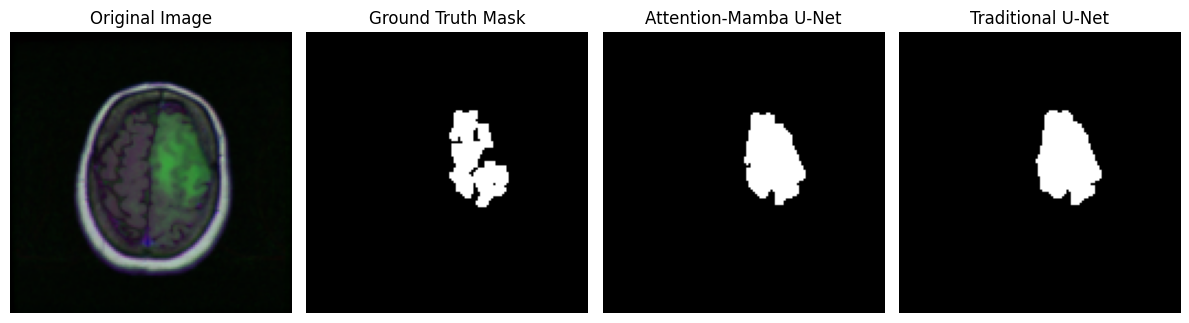

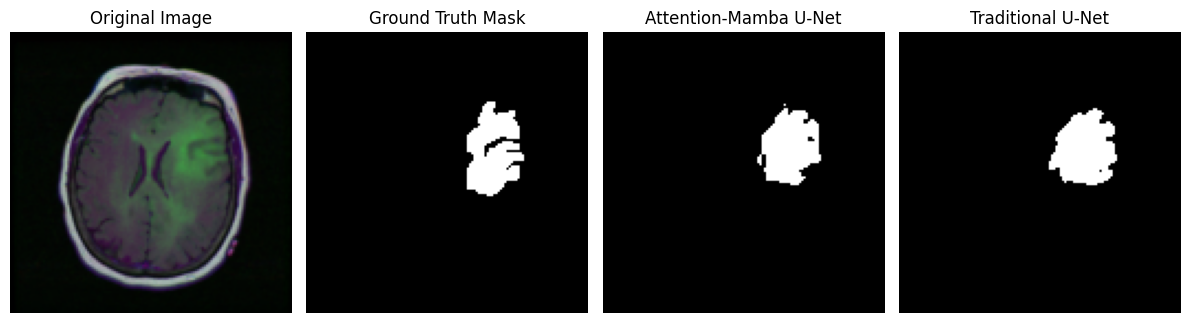

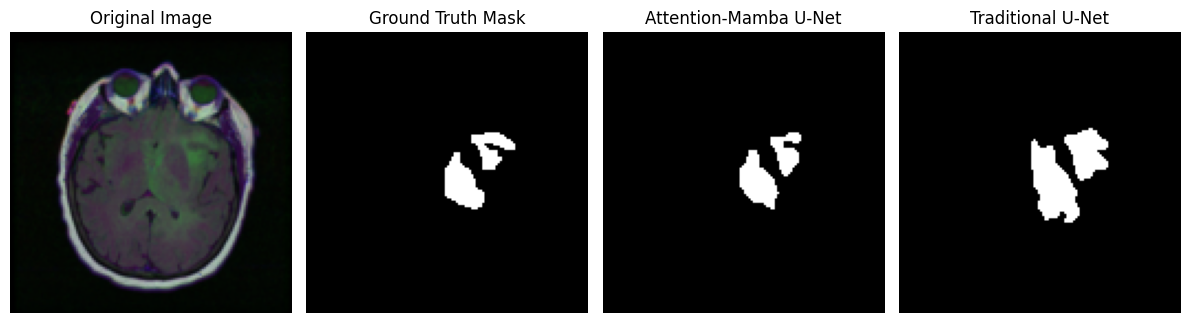

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize predictions of both models on a sample
def visualize_comparison(index):
    # Get image and ground truth from the full dataset
    image, mask = dataset[index]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_att = torch.sigmoid(attention_model(image_input)).squeeze().cpu().numpy()
        pred_unet = torch.sigmoid(unet_model(image_input)).squeeze().cpu().numpy()

    # Binarize predictions
    pred_att_bin = (pred_att > 0.5).astype(np.uint8)
    pred_unet_bin = (pred_unet > 0.5).astype(np.uint8)
    img_np = image.permute(1,2,0).cpu().numpy()
    mask_np = mask.squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(12,4))
    axs[0].imshow(img_np); axs[0].set_title("Original Image"); axs[0].axis('off')
    axs[1].imshow(mask_np, cmap='gray'); axs[1].set_title("Ground Truth Mask"); axs[1].axis('off')
    axs[2].imshow(pred_att_bin, cmap='gray'); axs[2].set_title("Attention-Mamba U-Net"); axs[2].axis('off')
    axs[3].imshow(pred_unet_bin, cmap='gray'); axs[3].set_title("Traditional U-Net"); axs[3].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize on a few samples
for idx in [0, 1, 2]:
    visualize_comparison(idx)


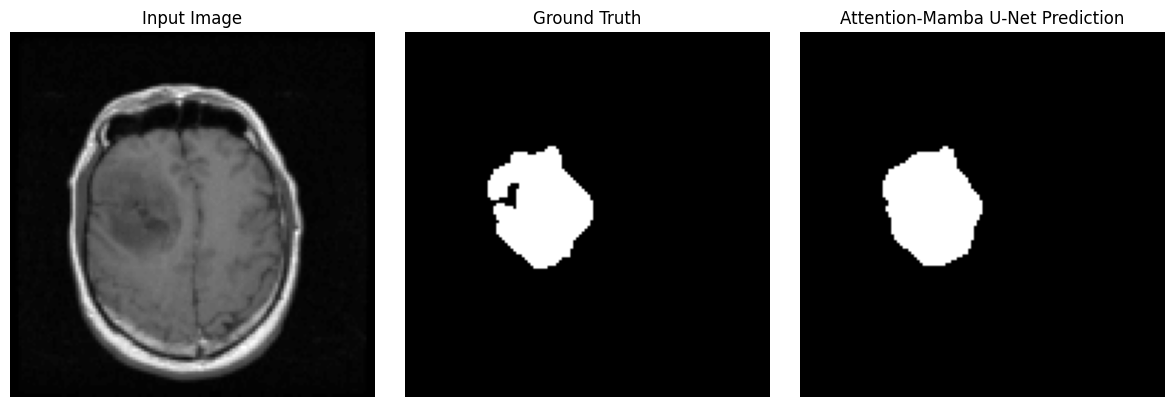

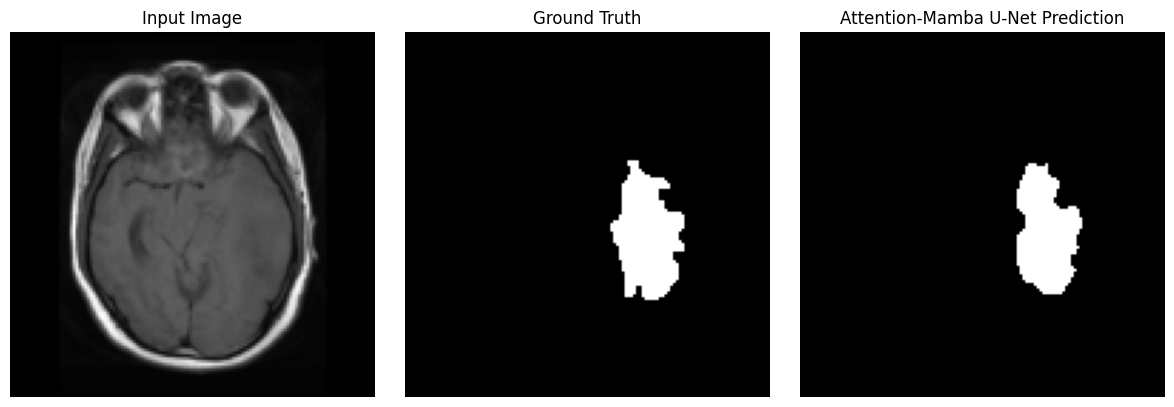

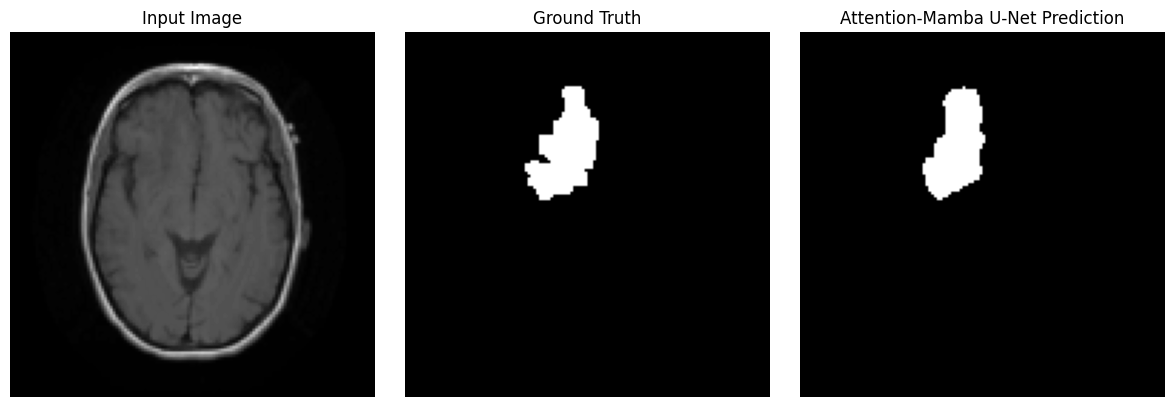

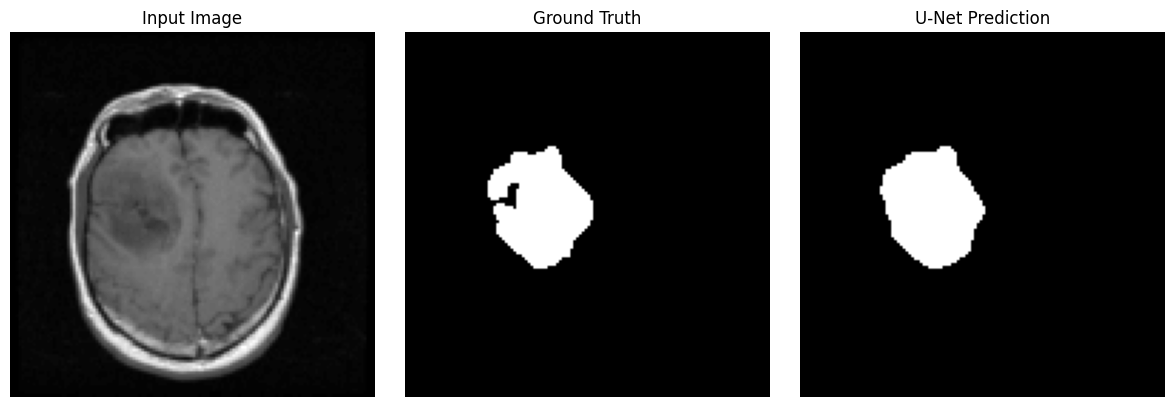

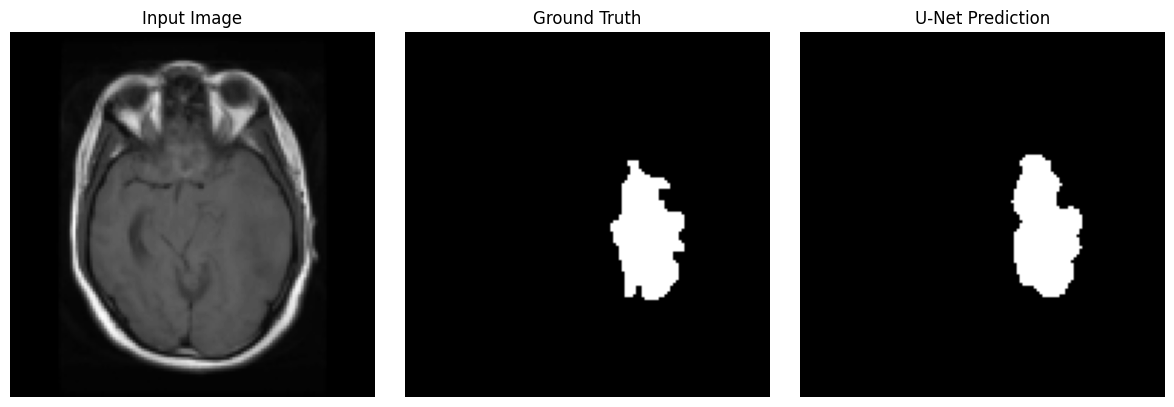

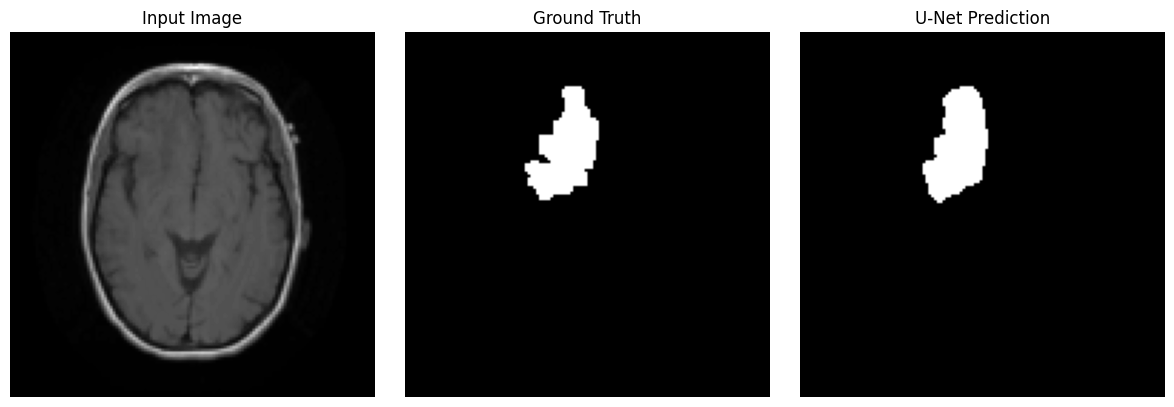

In [20]:
visualize_predictions(attention_model, val_loader, device, title='Attention-Mamba U-Net')
visualize_predictions(unet_model, val_loader, device, title='U-Net')


In [21]:
print("Comparison complete.")


Comparison complete.
